In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
from numpy import nan as NaN
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn import datasets
from sklearn.manifold import TSNE
%matplotlib inline

In [3]:
air_quality_path='AirQualityUCI/AirQualityUCI.csv'
BLE_labled_path='BLE_RSSI_dataset/iBeacon_RSSI_Labeled.csv'
BLE_unlabled_path='BLE_RSSI_dataset/iBeacon_RSSI_Unlabeled.csv'
aq_df=pd.read_excel('AirQualityUCI/AirQualityUCI.xlsx')
data2=pd.read_csv(BLE_labled_path)
data3=pd.read_csv(BLE_unlabled_path)

In [4]:
aq_df.shape[0]-aq_df.count()
#查看各列的NAN的情况,

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

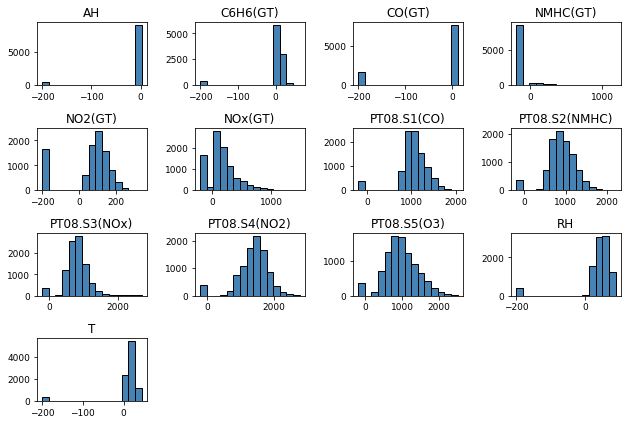

In [5]:
aq_df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
              xlabelsize=9, ylabelsize=9, grid=False)    
plt.tight_layout(rect=(0,0 , 1.5, 1.5))

#各个属性的一个分布情况, 我们能发现都有一定的缺失值和异常值.而且缺失值较多, 我们没办法直接删除处理

(array([8.443e+03, 0.000e+00, 2.640e+02, 2.460e+02, 1.380e+02, 8.900e+01,
        4.000e+01, 5.400e+01, 2.500e+01, 2.700e+01, 1.700e+01, 8.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00]),
 array([-200. , -107.4,  -14.8,   77.8,  170.4,  263. ,  355.6,  448.2,
         540.8,  633.4,  726. ,  818.6,  911.2, 1003.8, 1096.4, 1189. ]),
 <a list of 15 Patch objects>)

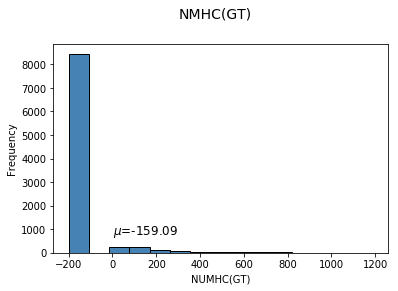

In [6]:
# NMHC 的表格没办法看的很清楚, 我们把它单独拿出来,看下分桶情况

fig = plt.figure(figsize = (6,4))
title = fig.suptitle("NMHC(GT)", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("NUMHC(GT)")
ax.set_ylabel("Frequency") 
ax.text(1.2, 800, r'$\mu$='+str(round(aq_df['NMHC(GT)'].mean(),2)), 
         fontsize=12)
freq, bins, patches = ax.hist(aq_df['NMHC(GT)'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)
freq,bins,patches

# 这个属性的缺失值较多, 大概有八千多条, 因此我们不考虑该属性

In [7]:
#类似这样的属性我们为了简化, 不再考虑 NMHC(GT) NOx(GT) NO2(GT) 属性, 仅对其他属性进行分析, 对于其他的属性, 我们删除其中的缺失值
# aq_df.columns.values
subset_attributes=['Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)',
       'PT08.S2(NMHC)',  'PT08.S3(NOx)', 
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
aq=aq_df[subset_attributes]
aq.replace(-200,NaN,inplace=True)
aq=aq.dropna(axis=0, how='any')
# aq
# aq=aq[~aq.isin([-200])]?


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [8]:
aq.isnull().values.any()

False

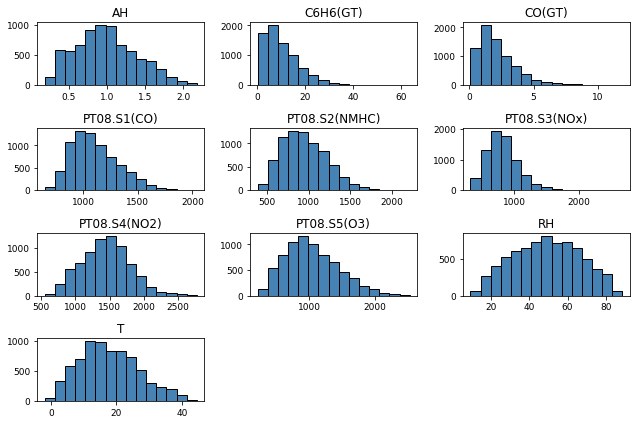

In [9]:
aq.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
              xlabelsize=9, ylabelsize=9, grid=False)    
plt.tight_layout(rect=(0,0 , 1.5, 1.5))

In [10]:
time=aq.Time.unique()
# time=sorted(list(map(lambda x: x.strftime("%H:%M:%S"), time)))
time0_df=aq[aq.Time==time[0]]
time0_df=time0_df.reset_index(drop=True)
data=round(time0_df.iloc[:,1:],2).values
data

array([[2.60000e+00, 1.36000e+03, 1.18800e+01, ..., 1.36000e+01,
        4.88800e+01, 7.60000e-01],
       [4.80000e+00, 1.58075e+03, 2.08000e+01, ..., 1.03500e+01,
        6.41700e+01, 8.10000e-01],
       [3.90000e+00, 1.50950e+03, 1.92900e+01, ..., 1.51500e+01,
        3.95500e+01, 6.80000e-01],
       ...,
       [1.60000e+00, 9.28000e+02, 5.54000e+00, ..., 1.70500e+01,
        2.53200e+01, 4.90000e-01],
       [1.10000e+00, 9.46750e+02, 3.95000e+00, ..., 1.85700e+01,
        2.65800e+01, 5.60000e-01],
       [1.20000e+00, 1.01467e+03, 4.59000e+00, ..., 2.28000e+01,
        2.17000e+01, 5.90000e-01]])

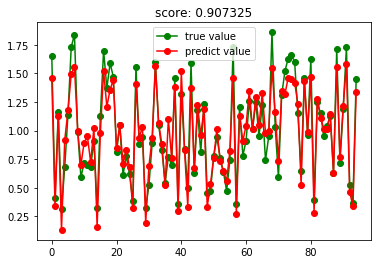

In [11]:
x=data[:,:-1]
y=data[:,-1:]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
model = linear_model.LinearRegression()
model.fit(x_train,y_train)
score = model.score(x_test, y_test)
result = model.predict(x_test)
plt.figure()
plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
plt.title('score: %f'%score)
plt.legend()
plt.show()

# model = linear_model.LinearRegression()
# scores = []
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# for i, (train, test) in enumerate(kfold.split(X, y)):
#  model.fit(X.iloc[train,:], y.iloc[train,:])
#  score = model.score(X.iloc[test,:], y.iloc[test,:])
#  scores.append(score)
# print(scores)

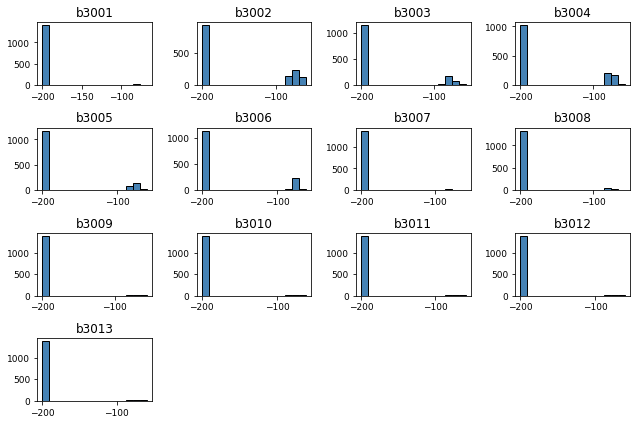

In [12]:
data2.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
              xlabelsize=9, ylabelsize=9, grid=False)    
plt.tight_layout(rect=(0,0 , 1.5, 1.5))
# labelled 数据展示

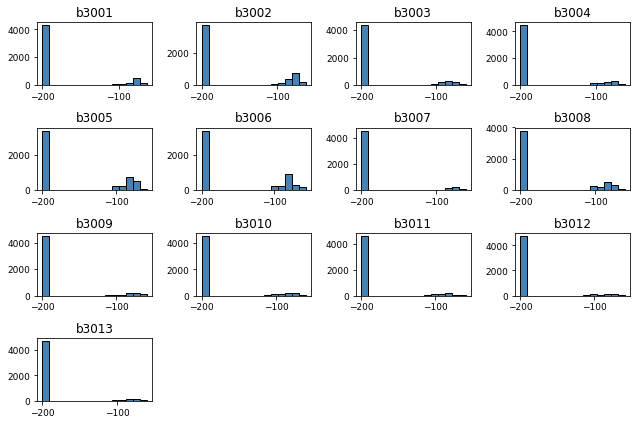

In [13]:
data3.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
              xlabelsize=9, ylabelsize=9, grid=False)    
plt.tight_layout(rect=(0,0 , 1.5, 1.5))
# unlabelled 数据展示

In [14]:
labels=data2.location.unique()
labeli=range(0,len(data2.location.unique()))
i=dict(zip(labels, labeli))
data2.location=data2.location.map(i)
data2.drop(columns=['date'],inplace=True)
data2
# 先将 location 进行划分, 映射为整数值

,location,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013
0,0,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
1,1,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
2,1,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
3,1,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
4,1,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
5,1,-200,-200,-82,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
6,1,-200,-200,-80,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
7,2,-200,-200,-86,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
8,3,-200,-200,-200,-75,-200,-200,-200,-200,-200,-200,-200,-200,-200
9,3,-200,-200,-200,-75,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [15]:
x=data2.values[:,1:]
y=data2.values[:,:1]
#分离出label 和 data

In [16]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# 抽取30%的数据作为测试集，其余作为训练集
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

# 创建SVM分类器
model = SVC()
# 用训练集做训练
model.fit(x_train,y_train)
# 用测试集做预测
prediction=model.predict(x_test )
print('准确率: ', metrics.accuracy_score(prediction,y_test))

准确率:  0.1572769953051643


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train,y_train)
prediction=clf.predict(x_test )
print('准确率: ', metrics.accuracy_score(prediction,y_test))

准确率:  0.2535211267605634


In [18]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(oob_score=True, random_state=10)
rf = rf.fit(x_train,y_train)
prediction=rf.predict(x_test )
print('准确率: ', metrics.accuracy_score(prediction,y_test))

准确率:  0.28169014084507044


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


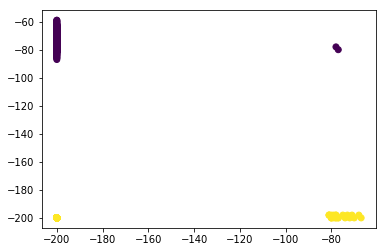

In [19]:

y = KMeans(n_clusters=2, random_state=9).fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()
#先通过 kmeans 对少量数据进行分类, 由图可知, 分类结果实在太差, 数据集缺失值较多. 

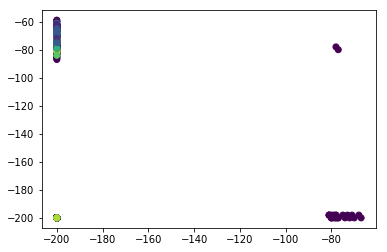

In [20]:

y_pred = DBSCAN(eps=0.1,min_samples = 2).fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=y_pred)
plt.show()
#DBscan 算法同样也是如此, 无论 eps 和 min_samples 取何值, 实验结果均比较差.


In [22]:
#为了有更好的可视化结果, 采用 iris 数据集

iris_df = datasets.load_iris()

tsne = TSNE(learning_rate=100)

transformed = tsne.fit_transform(iris_df.data)
#将数据集降维到二维空间上
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]


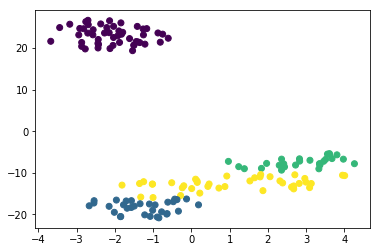

In [27]:
y = KMeans(n_clusters=4, random_state=10).fit_predict(iris_df.data)
plt.scatter(x_axis, y_axis, c=y)
plt.show()

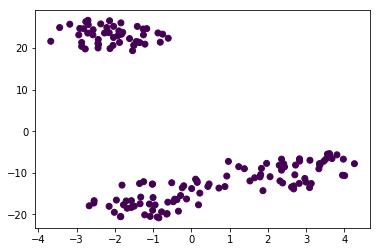

In [36]:
y = DBSCAN(eps=0.2,min_samples =20).fit_predict(iris_df.data)
plt.scatter(x_axis, y_axis, c=y)
plt.show()

In [43]:
iris_df.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')